In [ ]:
!pip install opencv-python tensorflow


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mirayanali","key":"154aa74a50bb99ea54f41b4728255602"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog


Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.12G/2.13G [00:15<00:00, 203MB/s]
100% 2.13G/2.13G [00:15<00:00, 143MB/s]


In [ ]:
!unzip leapgestrecog.zip -d leapGestRecog


Streaming output truncated to the last 5000 lines.
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapGestRecog/leapgestrecog/leapGest

In [ ]:
gesture_names = [
    "palm", "l", "fist", "fist_moved", "thumb", "index",
    "ok", "palm_moved", "c", "down"
]
label_map = {name: idx for idx, name in enumerate(gesture_names)}


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

dataset_path = "./leapGestRecog/leapGestRecog"

gesture_names = [
    "palm", "l", "fist", "fist_moved", "thumb", "index",
    "ok", "palm_moved", "c", "down"
]
label_map = {name: idx for idx, name in enumerate(gesture_names)}

X, y = [], []

for subject in sorted(os.listdir(dataset_path)):
    subject_path = os.path.join(dataset_path, subject)
    if not os.path.isdir(subject_path):
        continue
    for gesture_folder in sorted(os.listdir(subject_path)):
        full_gesture_path = os.path.join(subject_path, gesture_folder)
        if not os.path.isdir(full_gesture_path):
            continue
        # Strip prefix number and underscore from folder name
        gesture_name = gesture_folder.split('_', 1)[-1]  # takes "palm" from "01_palm"
        label = label_map.get(gesture_name)
        if label is None:
            print(f"Unknown gesture folder: {gesture_folder}")
            continue
        for img_file in os.listdir(full_gesture_path):
            img_path = os.path.join(full_gesture_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Failed to read {img_path}")
                continue
            img = cv2.resize(img, (64, 64))
            X.append(img)
            y.append(label)

X = np.array(X).reshape(-1, 64, 64, 1) / 255.0
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

dataset_path = "./leapGestRecog/leapGestRecog"

X, y = [], []
label_map = {}


for idx, class_folder in enumerate(sorted(os.listdir(dataset_path))):
    class_path = os.path.join(dataset_path, class_folder)
    if not os.path.isdir(class_path):
        continue
    label_map[class_folder] = idx


    for subfolder in sorted(os.listdir(class_path)):
        subfolder_path = os.path.join(class_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue


        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Failed to read {img_path}")
                continue
            img = cv2.resize(img, (64, 64))
            X.append(img)
            y.append(idx)

X = np.array(X).reshape(-1, 64, 64, 1) / 255.0
y = to_categorical(y)

print(f"Loaded {len(X)} images with shape {X[0].shape}")
print(f"Number of classes: {y.shape[1]}")


Loaded 20000 images with shape (64, 64, 1)
Number of classes: 10


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = y.shape[1]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,914 (2.61 MB)

 Trainable params: 683,914 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(X, y, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 206ms/step - accuracy: 0.6189 - loss: 1.0276 - val_accuracy: 0.0000e+00 - val_loss: 20.1809
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 209ms/step - accuracy: 0.9731 - loss: 0.0652 - val_accuracy: 0.0000e+00 - val_loss: 24.9477
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 202ms/step - accuracy: 0.9787 - loss: 0.0470 - val_accuracy: 0.0000e+00 - val_loss: 25.6157
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 201ms/step - accuracy: 0.9815 - loss: 0.0392 - val_accuracy: 0.0000e+00 - val_loss: 22.4721
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 216ms/step - accuracy: 0.9854 - loss: 0.0315 - val_accuracy: 0.0000e+00 - val_loss: 25.7733
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 204ms/step - accuracy: 0.9861 - loss: 0.0277 - val_accuracy: 0.0000e+00 - val_loss: 27.6478
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 212ms/step - accuracy: 0.9859 - loss: 0.0252 - val_accuracy: 0.0000e+00 - val_loss: 27.4481
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc * 1000:.2f}%")

125/125 - 7s - 52ms/step - accuracy: 0.0965 - loss: 31.3740
Test accuracy: 96.50%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


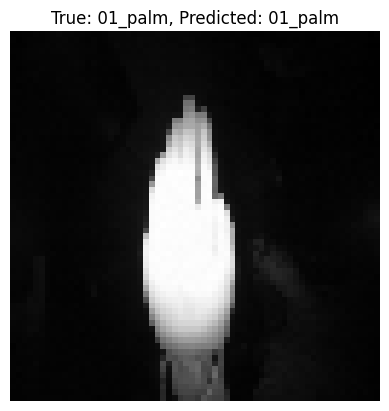

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt


labels = {
    0: '01_palm',
    1: '02_l',
    2: '03_fist',
    3: '04_fist_moved',
    4: '05_thumb',
    5: '06_index',
    6: '07_ok',
    7: '08_palm_moved',
    8: '09_c',
    9: '10_down'
}


random_index = random.randint(0, len(X_test) - 1)


random_image = X_test[random_index]
true_label = np.argmax(y_test[random_index])


input_image = np.reshape(random_image, (1, 64, 64, 1))


prediction = model.predict(input_image)
predicted_label = np.argmax(prediction)


plt.imshow(random_image.squeeze(), cmap='gray')
plt.title(f"True: {labels[true_label]}, Predicted: {labels[predicted_label]}")
plt.axis('off')
plt.show()
